In [22]:
from functions import * # custom functions from the file functions.py in the same folder
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert
from numpy.linalg import inv


### Possible sources
https://web.stanford.edu/~yzliao/pub/master_thesis.pdf

https://ieeexplore.ieee.org/document/1057115 (*)

https://pdfs.semanticscholar.org/e8b1/708d43984b7a65410d0b2be084b0a38467d3.pdf?_ga=2.183898534.1632924675.1584907320-1797825897.1583541938

https://www.gaussianwaves.com/2014/07/best-linear-unbiased-estimator-blue-introduction/

## General task info
We have the following problem of a complex exponential embedded in white, complex Gaussian noise

\begin{equation}
x(t) = Ae^{i(\omega_0 t + \phi)} + w(t)
\end{equation}

- Amplitude $A > 0$
- Frequancy $\omega_0 > 0$
- Phase $-\pi < \phi < \pi$

QUICK MOTIVATION: 

1. If we want to extract a baseband signal we need to estimate these parameters of the carrier first. 

2. Also variations in sensors (local oscillator) creates the need to synchronize to a common frequency reference in a master-slave architecture.

Our signal is sampled and bandlimited:
\begin{equation}
x[n] = A e^{i(\omega_0 nT +\phi)} + w_r[n] + i w_i[n]
\end{equation}

Where
$$
\begin{align}
& E[w[n]] = E[w_r[n] + i w_i[n]] = 0  \\
& var(w_r[n]) = var(w_i[n]) = \sigma^2 \\
& E[w_r[n] w_i[n]] = 0
\end{align}
$$

A best linear unbiased estimator (BLUE) is used in the high signal-to-noise range. Computer simulations are done in this Notebook. We also have:

In [23]:
fs = 10**6 # Hz, sampling rate
T = 1/fs # s, time step

f_0 = 10**5 # Hz
w_0 = 2*np.pi*f_0
phase = np.pi/8
A = 1

n_0 = 0
N = 100
SNR = 30

# N samples from n = n_0 to n = n_0+N-1
# SNR = A^2 / (std^2) [exercise gives SNR = A^2 / (2*std^2)] 



In [24]:
# Move these outside in a different .py file maybe
# Cramer-Rao lower bounds

def var_est_w(var, A, T, N):
    return 12*var /(A**2 * T**2 * N*(N**2-1))

def var_est_phi(var, A, n_0, N):
    P = N*(N-1)/2
    Q = N*(N-1)*(2*N-1)/6
    num = 12*var*(n_0**2 *N + 2*n_0*P +Q)
    den = A**2 * N**2 * (N**2 - 1)
    return num/den

# Setting n_0 = -P/N apparently gives a diagonal matrix     (how & where?) so frequency and phase can be analysed     independently

## Project description: BLUE for high SNRs

**Quote**:
**The maximum-likelihood estimators require finding the peak of the periodogram of
the obsewed signal sequence. Rife and Boorstyn suggest first
using a fast Fourier transform to find a coarse estimate of the
peak location and then refining the estimate with a numerical
search procedure. The autoregressive model technique requires
lag product computations, an effective matrix inversion, and root
finding. The linear regression estimators do not require any of
these computations, but only an arc taangent, phase unwrapping,
and simple sums. In some applications it is
useful to plot the instantaneous signal phase to see various
anomalies such as periodic variations in phase slope or sudden
changes in SNR. This sequence is generated for the linear regression estimators but is hidden in the maximum-likelihood and
autoregressive methods. **

MLE sometimes requires too much memory and computational power. We can do the approximation that the additive noise is viewed as an equivalent phase noise, opening for frequency and phase estimation by linear regression on the signal phase

\begin{equation}
x[n] = A e^{i(\omega_0 n T + \phi)} + w[n] \approx A e^{i(\omega_0 n T + \phi + v[n])},
\end{equation}

where $v[n]$ is zero mean, iid. noise. It can be shown to be good under high SNRs. From Steven Tretter's paper, *Estimating the Frequency of a Noisy Sinusoid by Linear Regression*:

\begin{equation}
x[n] = A e^{i(\omega_0 n T + \phi)} (1 + v[n])
\end{equation}

To achieve this we must have that $v[n] = \frac{1}{A} w[n] e^{-i(\omega_0 n T + \phi)} $, with a variance of $\frac{\sigma^2}{A^2} \propto 1/\text{SNR}$ (**check exactly what is correct, the author has a different definition of SNR than the exercise**). Letting $v[n] = v_R[n] + v_I[n]$, we can split it into an amplitude and phase component:

\begin{equation}
1 + v[n] = \bigg( [1+v_R[n]]^2 + v_I^2[n] \bigg)^{1/2} \cdot e^{i \tan^{-1} \frac{v_I[n]}{1+v_R[n]}}
\end{equation}

If the $\text{SNR} >> 1$, the above equation simplifies a lot

\begin{equation}
1 + v[n] \approx e^{i \tan^{-1} v_I[n]} \approx e^{i v_I[n]}
\end{equation}

If we go back we see that 

\begin{equation}
x[n] = A e^{i(\omega_0 n T + \phi)} (1 + v[n]) = A e^{i(\omega_0 n T + \phi + v_I[n])}, 
\end{equation}

and the variance of $v_I[n]$ is half the variance of $v[n]$ (Why? I think it is how variances sum: variance of sum = sum of variances). To be consistent with the exercise text, $v_I[n]$ is from here just written as $v[n]$.

All info is now in phase angle of observations:

\begin{equation}
\angle x[n] = \omega_0 n T + \phi + v[n],
\end{equation}

which is a linear with noise, and we can use regression to find the phase and frequency. $v[n]$ **IS NOT** Gaussian, so we use BLUE (apparently good for unknown PDFs, write why). Phase unwrapping is one thing we need to consider, since we from computations get $ \angle x[n] \in [-\pi/2, \pi/2]$. We need high SNRs. We will use $\texttt{np.unwrap}$.

### 2a) Experiment with the unwrap function and plot som of the results for low (-10 dB) and high (30 dB) SNRs.

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

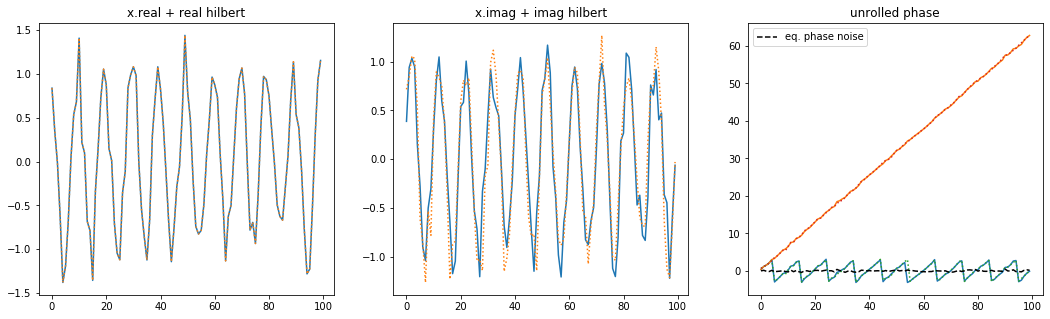

In [25]:
def make_x(A, w_0, phase, T, SNR, n_0, N):
    var = A**2/SNR
    std = np.sqrt(var)

    # Complex Gaussian noise
    w = np.random.normal(0, std, N) +  \
        np.random.normal(0, std, N)*1j
    
    # n-values to use for computation
    n = np.linspace(n_0, n_0+N-1, N)

    # x array
    x = A*np.exp(1j*(w_0*n*T + phase)) + w 

    # The equivalent phase noise, used for comparison
    v = 1/A*w*np.exp(-1j*(w_0*n*T + phase))
    return x, v.imag

x,v = make_x(A, w_0, phase, T, SNR, n_0, N)


ang_x = np.log(x/A)/1j
ang_x = ang_x.real
ang_x_unwrapped = np.unwrap(ang_x)

# testing hilbert transform, as we normally would get a REAL signal
x_hilb = hilbert(x.real)
ang_x_hilb = np.log(x_hilb/A)/1j
ang_x_hilb = ang_x_hilb.real
ang_x_unwrapped_hilb = np.unwrap(ang_x_hilb)

fig = plt.figure(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
ax1.set_title('x.real + real hilbert')
ax2 = plt.subplot(1,3,2)
ax2.set_title('x.imag + imag hilbert')
ax3 = plt.subplot(1,3,3)
ax3.set_title('unrolled phase')

ax1.plot(x.real)
ax1.plot(x_hilb.real,':')

ax2.plot(x.imag)
ax2.plot(x_hilb.imag,':')

ax3.plot(ang_x)
ax3.plot(ang_x_unwrapped)
ax3.plot(ang_x_hilb,':')
ax3.plot(ang_x_unwrapped_hilb,':')
ax3.plot(v,'k--', label='eq. phase noise')
ax3.legend()
plt.tight_layout


## BLUE - what it is
- Sometimes problems have no MVU estimator (or it might be complicated to calculate in practice)
- Unknown pdf (non-gaussian) precludes use of CRLB
- Fit to model o be linear in observ. data, using two first moments of pdf. Not MVU unl. model is linear.


- Deriving BLUE, E[theta]
- Variance of estimator, minimize a^T C a

Text(0.5, 1.0, 'Covariance matrix, noise')

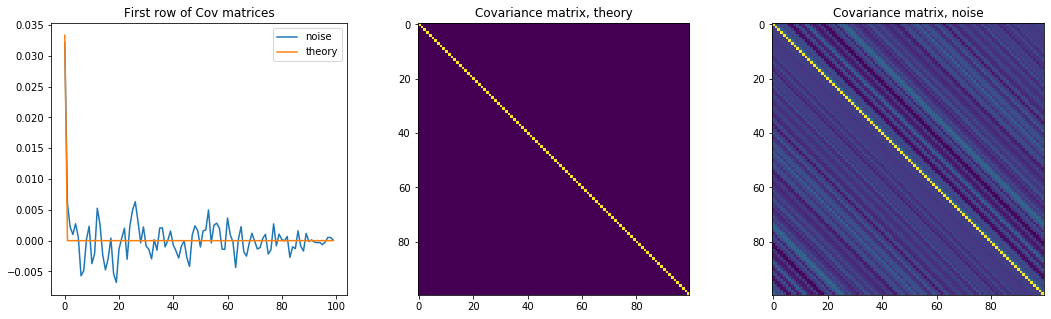

In [36]:
# Covariance matrix
# Alt. 1, using the defined SNR
C_theory = np.eye(N)/(SNR) # 1/2SNR is the variance
 
# Alt. 2, using the generated noise values
acorr = np.correlate(v, v, mode='full')[N-1:]/(N)
C_meas = np.zeros((N,N))
for i in range(N):
    C_meas[i,:] = np.roll(acorr,i)

### PLOTTING ###
fig = plt.figure(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
ax1.plot(acorr, label = 'noise')
ax1.plot(C_theory[0,:], label = 'theory')
ax1.legend()
ax1.set_title('First row of Cov matrices')

ax2 = plt.subplot(1,3,2)
ax2.imshow(C_theory)
ax2.set_title('Covariance matrix, theory')

ax3 = plt.subplot(1,3,3)
ax3.imshow(C_meas)
ax3.set_title('Covariance matrix, noise')

[6.28929729e+05 3.81958729e-01]
628318.5307179586
0.39269908169872414


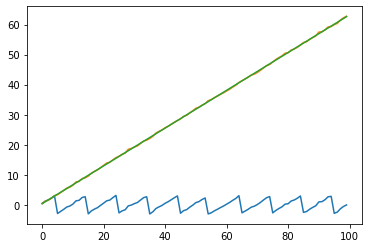

In [27]:
# Code for BLUE
# model: ang_x_unwrapped[n] = wT*n + phi + v[n]
def BLUE_iid(ang_x_unwrapped, n_0, T, C):
    
    N = len(ang_x_unwrapped)
    
    # make H matrix
    h1 = np.arange(n_0, n_0+N)*T
    h2 = np.ones(N)
    H = np.vstack([h1,h2]).T

    # calculate parameters
    p = inv( H.T @ inv(C) @ H ) @ H.T @ inv(C) @ ang_x_unwrapped
    model_fit = h1*p[0] + p[1]

    return p, model_fit

p, model_fit = BLUE_iid(ang_x_unwrapped, n_0, T, C_theory)

print(p)
print(w_0)
print(phase)


plt.plot(ang_x)
plt.plot(ang_x_unwrapped)
plt.plot(model_fit)



### 2b) Compare the BLUE estimator with the CRLB wrt. the frequency and phase error variances for the following parameters.

- Samples number N = 513, which gives n_0 = -256
- SNRs (in decibel): -10 through 40, in steps of 10 dB.

Håvard: Vi burde sjekke pdf-en til støyet og måle opp mot teori. Gaussisk -> ? 

In [28]:
# insert code hhhuihiuh

An alternatiove approach that doesn’t rely on phase unwrapping is based on the difference between two phase estimates.

\begin{equation}
\angle x[n+1] - \angle x[n] = \omega_0 T + v[n+1] - v[n].
\end{equation}

Here the noise is no longer white between observations. 

### 2c) Use the BLUE for colored noise to compute estimates for the same parameters as in the previous problem.

Note that there is no phase estimate directly available with this approach. Instead we use the direct ML estimate,which is in closed form when $\hat{\omega}$ is known:

\begin{equation}
\hat{\phi} = \angle \big[ e^{-i\hat{\omega} n_0 T} F(\hat{\omega}) \big]
\end{equation}



### frequency estimate

Text(0.5, 1.0, ' w_0 est = 630908\n w_0 tru = 628319')

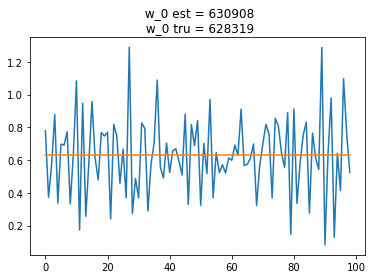

In [63]:

# calculate difference
diff_ang = ang_x[1:N]-ang_x[0:N-1]
# only way I see to spikes from wrap-around
diff_ang[diff_ang < -np.pi] += 2*np.pi

# model: diff_ang[n] = wT + v[n+1] - v[n]
def BLUE_colored(diff_ang, T):
    
    N = len(diff_ang)
    
    # covariance matrix, colored noise
    x = np.ones(N)
    A = -np.diag(x) + np.diag(x[:-1], 1)
    C = A @ A.T

    # make H matrix
    #h1 = np.arange(n_0, n_0+N)*T
    H = np.ones(N)*T #we only need this one now
    #H = np.vstack([h1,h2]).T

    # calculate parameters
    p = 1/( H.T @ inv(C) @ H ) * H.T @ inv(C) @ diff_ang
    model_fit = H*p

    return p, model_fit

w_est, fit = BLUE_colored(diff_ang, T)

# plot the fit:
plt.plot(diff_ang)
plt.plot(fit)
plt.title(' w_0 est = ' + str(int(w_est)) + '\n w_0 tru = ' + str(round(w_0)))

### phase estimate

\begin{equation}
\hat{\phi} = \angle \big[ e^{-i\hat{\omega} n_0 T} F(\hat{\omega}) \big]
\end{equation}


Estimated phi is: 0.40820586024949446
True phi is: 0.39269908169872414
w is here:628318.5307179586

using estimated w of:630908.6442520018
we estimate phi to be:0.2813951185997105


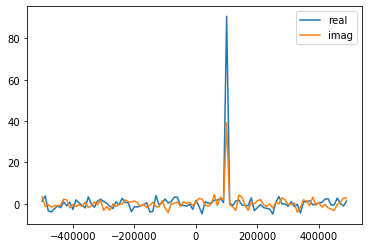

In [84]:
exp_part = np.exp(-1j*w_est*n_0*T)

# The specific component in a "more true" way
# by taking the dot product w/ exponential function of same frequency...
F = np.fft.fft(x)
F = np.fft.fftshift(F)

f_fft = np.fft.fftfreq(N, d=T)
f_fft = np.fft.fftshift(f_fft)

i_max = np.argmax(abs(F))
phi_est = np.angle(F[i_max])

plt.plot(f_fft, F.real, label='real')
plt.plot(f_fft, F.imag, label='imag')
plt.legend()

print('Estimated phi is: ' + str(phi_est))
print('True phi is: ' + str(phase))
print('w is here:' + str(2*np.pi*f_fft[i_max]))


# n-values to use for computation
n = np.linspace(n_0, n_0+N-1, N)
# complex exp array with known angular frequency, 0 phase
cexp_w_est = np.exp(-1j*(w_est*n*T))
# inner product
prod = cexp_w_est @ x
new_phase_est = np.angle(prod)
print('')
print('using estimated w of:' + str(w_est))
print('we estimate phi to be:' + str(new_phase_est))